[View in Colaboratory](https://colab.research.google.com/github/Luvata/PatternRecognition/blob/master/1A1B.ipynb)

# Hammer, Hanging man, White & Black shooting star

## Get Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator
from datetime import timedelta
from matplotlib.finance import candlestick_ohlc
from google.colab import files

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [0]:
stock_code = ['AAPL','JPM','GOOGL','AMZN','MSFT','JNJ','BAC','WMT','INTC','CSCO']

In [0]:
files.upload()

In [15]:
stocks = []
for code in stock_code :
  df = pd.read_csv(code+'.csv',
                   index_col=0,
                   parse_dates=True,
                   infer_datetime_format=True)
  print(code,df.shape)
  stocks.append(df)
  
print('total: ',len(stocks))

AAPL (4600, 5)
JPM (4600, 5)
GOOGL (3438, 5)
AMZN (4600, 5)
MSFT (4600, 5)
JNJ (4600, 5)
BAC (4600, 5)
WMT (4600, 5)
INTC (4600, 5)
CSCO (4600, 5)
total:  10


## Helper function

In [0]:
def plot_candle(quotes,title,pattern_name,selected_date,date1=None,date2=None):
    # quotes : pandas dataframe
    # sample : plot_candle2(AP_df,title='Test',pattern_name='Hanging Man',selected_date='2005-04-29',date1='2005-04-07',date2='2005-05-25')
    if date1 is None:
        all_date = quotes.index.date
        date1 = str(all_date[0])
        date1 = str(all_date[-1]) # lastest
        
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
    dayFormatter = DateFormatter('%d')      # e.g., 12

    # select desired range of dates
    quotes2 = quotes[(quotes.index >= date1) & (quotes.index <= date2)]
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)
    # ax.xaxis.set_minor_formatter(dayFormatter)

    # plot_day_summary(ax, quotes, ticksize=3)
    candlestick_ohlc(ax, zip(mdates.date2num(quotes2.index.to_pydatetime()),
                         quotes2['open'], quotes2['high'],
                         quotes2['low'], quotes2['close']),
                 width=0.6,colordown='red',colorup='green')

    ax.xaxis_date()
    ax.autoscale_view()
    fig.set_size_inches(20,10)
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_title(title)
    ymin, ymax = ax.get_ylim()
    ax.annotate(pattern_name, xy = (selected_date,quotes.loc[selected_date].high ),xytext=(selected_date,quotes.loc[selected_date].high + (ymax-ymin)/6 ),
                arrowprops = dict(facecolor='black',width=1,shrink=0.25))
    plt.show()

In [0]:
def lookbackward_15days(data,index,down=True):
  # defaults for Hammer : 8/15 days down
  count = 1
  day = 0
  l = data.shape[0]
  while(count < 16):
    next_index = index + count
    if(next_index > l-1):
      return day
    row = data.iloc[next_index]
    close = row.close
    open = row.open
    # print(open,close)
    if(down):
      if (open > close):
        day +=1
      # print(next_index,open,close)
    else:
      if(close > open) :
        day += 1
    count += 1
    
  return day



In [0]:
def lookforward_15days(data,index,down=False): 
  # default for Hammer : 8/15 days up
  count = 1
  day = 0
  while(count < 16):
    next_index = index - count
    if(next_index < 0) :
      return day
    row = data.iloc[next_index]
    close = row.close
    open = row.open
    if(down):
      if (open > close):
        day +=1
    else:
      if(close > open):
        day+=1
    count += 1
  return day



In [0]:
def Hammer(open,high,low,close,threshold):
  if not close-low == 0:
    if( (open-low)/(close-low) >= threshold and (high-close) < (close-open) ):
      return True
  return False

def HangingMan(open,high,low,close,threshold):
  if not open-low == 0:
    if( (close-low)/(open-low) >= threshold and (high-open) < (open-close) ):
      return True
  return False

In [0]:
def BlackSS(open,high,low,close,threshold):
  if not high-close == 0:
    if( (high-open)/(high-close) >= threshold and (close-low) < (open-close)):
      return True
  return False

def WhiteSS(open,high,low,close,threshold):
  if not high-open == 0:
    if( (high-close)/(high-open) >= threshold and (open-low) < (close-open)):
      return True
  return False

In [0]:
func = ['Hammer','HangingMan','BlackSS','WhiteSS']

In [0]:
def traverse_HH(data, name, func_pattern, pattern_name ,threshold=0.9,display=False):
  # func_pattern : delegate
  appear = []
  correct = []
  l = data.shape[0]
  for i in range(l):
    day = data.iloc[[i]]
    close = day.close[0]
    open = day.open[0]
    high = day.high[0]
    low = day.low[0]
    if(func_pattern(open,high,low,close,threshold)):
      appear_day = day.index[0].to_pydatetime()
      if(lookbackward_15days(data,i) >= 8):
        appear.append(appear_day)
        if(lookforward_15days(data,i) >=8):
          correct.append(appear_day)
          if display:
            date1 = appear_day - timedelta(days=25)
            date2 = appear_day + timedelta(days=25)
            # plot_candle2(AP_df,title='Test',pattern_name='Hanging Man',selected_date='2005-04-29',date1='2005-04-07',date2='2005-05-25')
            plot_candle(data,title= name+' ' +str(appear_day),pattern_name=pattern_name,selected_date=appear_day,date1=date1,date2=date2)
  result = {}
  result['appear'] = appear
  result['correct'] = correct
  result['threshold'] = threshold
  result['accuracy'] = None if len(appear) == 0 else len(correct)/len(appear)
  result['name'] = name
  return result    
        
  

In [0]:
def traverse_star(data, name, func_pattern, pattern_name ,threshold=0.9,display=False):
  # func_pattern : delegate
  appear = []
  correct = []
  l = data.shape[0]
  for i in range(l):
    day = data.iloc[[i]]
    close = day.close[0]
    open = day.open[0]
    high = day.high[0]
    low = day.low[0]
    if(func_pattern(open,high,low,close,threshold)):
      appear_day = day.index[0].to_pydatetime()
      if(lookbackward_15days(data,i,down=False) >= 8):
        appear.append(appear_day)
        if(lookforward_15days(data,i,down=True) >=8):
          correct.append(appear_day)
          if display:
            date1 = appear_day - timedelta(days=25)
            date2 = appear_day + timedelta(days=25)
            # plot_candle2(AP_df,title='Test',pattern_name='Hanging Man',selected_date='2005-04-29',date1='2005-04-07',date2='2005-05-25')
            plot_candle(data,title= name+' ' +str(appear_day),pattern_name=pattern_name,selected_date=appear_day,date1=date1,date2=date2)
  result = {}
  result['appear'] = appear
  result['correct'] = correct
  result['threshold'] = threshold
  result['accuracy'] = None if len(appear) == 0 else len(correct)/len(appear)
  result['name'] = name
  return result    
        
  

#### Thử với black shooting star :

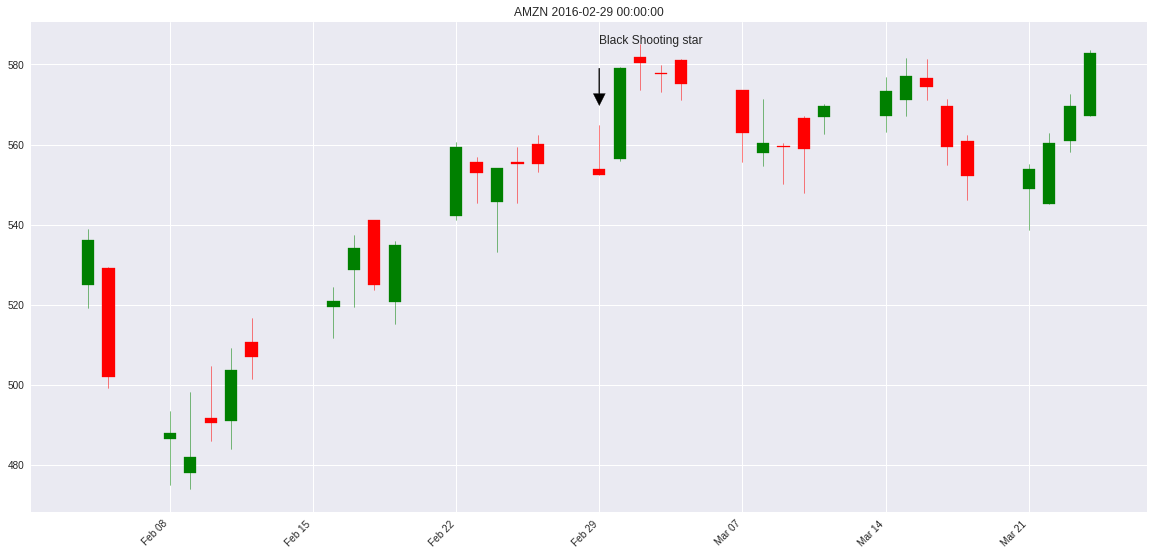

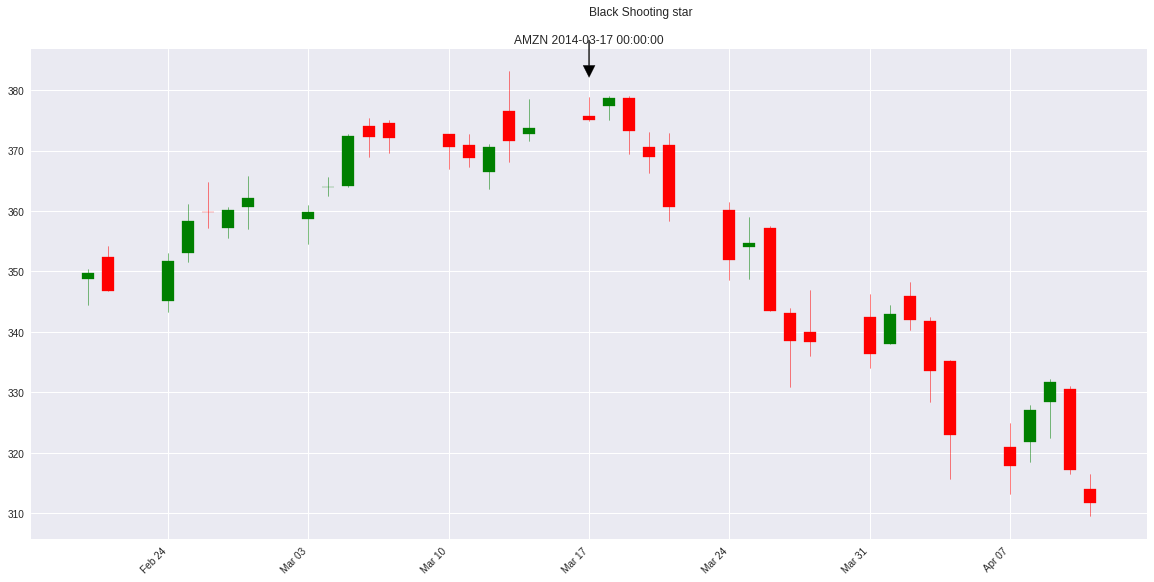

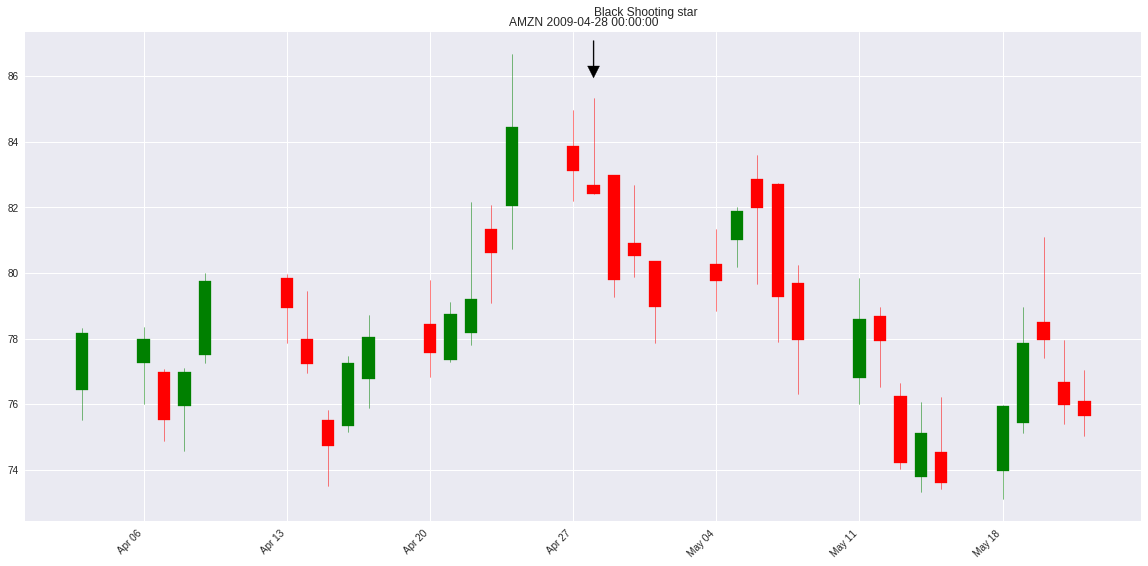

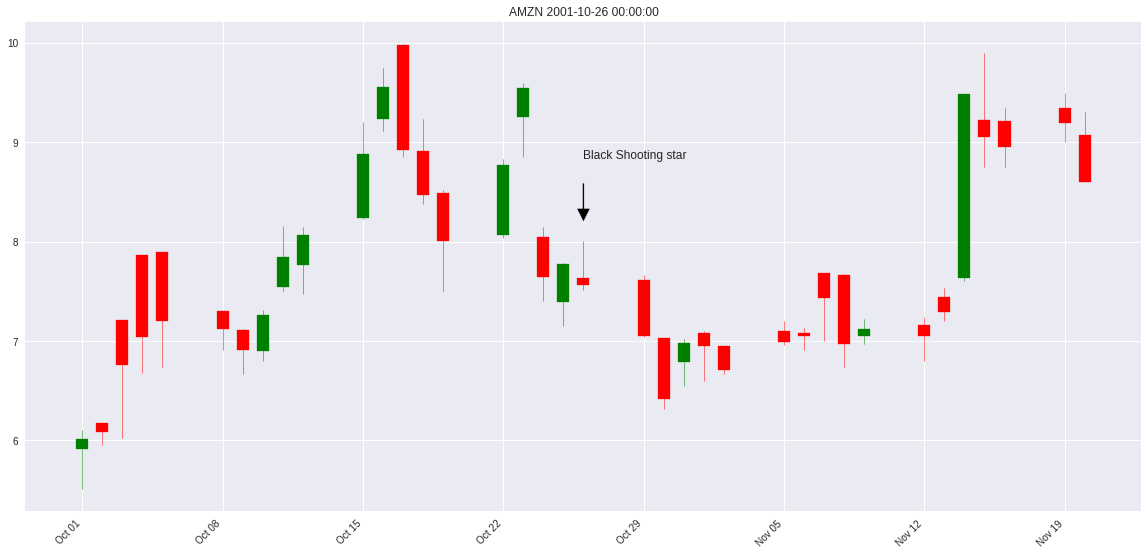

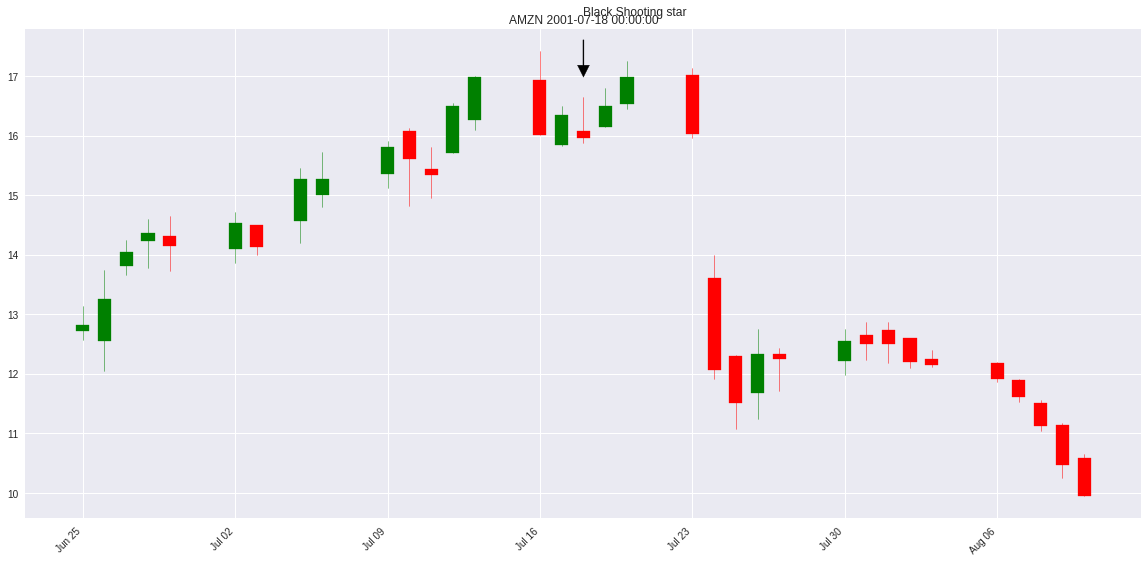

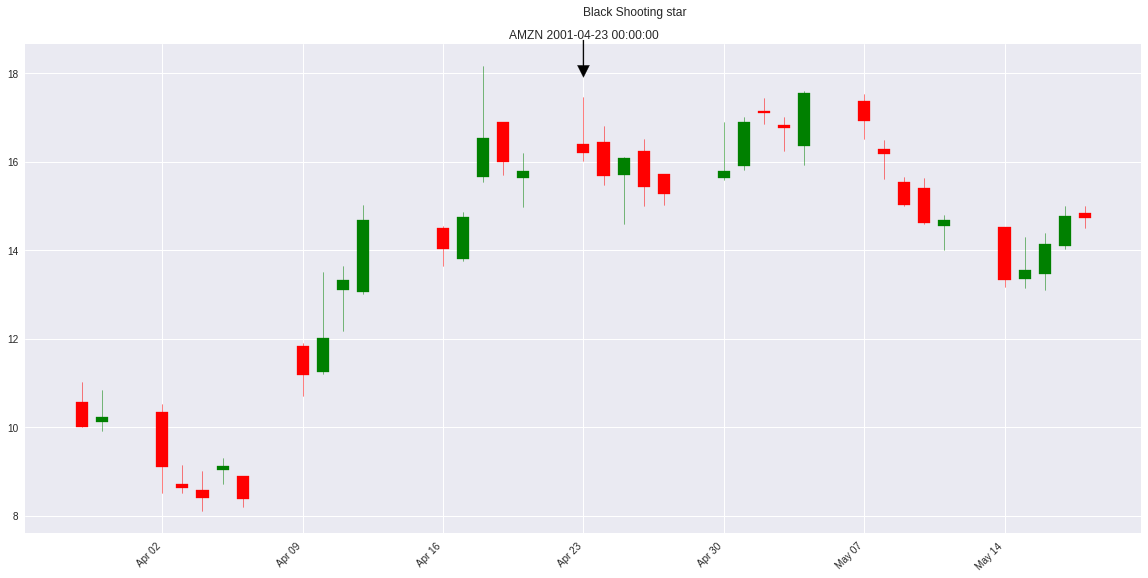

{'accuracy': 0.75,
 'appear': [datetime.datetime(2016, 2, 29, 0, 0),
  datetime.datetime(2014, 3, 17, 0, 0),
  datetime.datetime(2009, 4, 28, 0, 0),
  datetime.datetime(2007, 4, 9, 0, 0),
  datetime.datetime(2007, 3, 5, 0, 0),
  datetime.datetime(2001, 10, 26, 0, 0),
  datetime.datetime(2001, 7, 18, 0, 0),
  datetime.datetime(2001, 4, 23, 0, 0)],
 'correct': [datetime.datetime(2016, 2, 29, 0, 0),
  datetime.datetime(2014, 3, 17, 0, 0),
  datetime.datetime(2009, 4, 28, 0, 0),
  datetime.datetime(2001, 10, 26, 0, 0),
  datetime.datetime(2001, 7, 18, 0, 0),
  datetime.datetime(2001, 4, 23, 0, 0)],
 'name': 'AMZN',
 'threshold': 0.8}

In [33]:
traverse_star(stocks[3],stock_code[3],BlackSS,'Black Shooting star',threshold=0.8,display=True)

## Calculate accuracy :

In [0]:
list_threshold = [0.9,0.8,0.75,0.66,0.5]

In [0]:
summary_hammer = []
summary_hanging = []
for t in list_threshold:
  for i in range(len(stocks)):
    name = stock_code[i]
    df = stocks[i]
    result_hammer = traverse_HH(df,name,Hammer,'Hammer',threshold=t,display=False)  
    h1 = {'name': result_hammer['name'],'t':t,'appear':len(result_hammer['appear']),'correct':len(result_hammer['correct']),'acc':result_hammer['accuracy']}
    summary_hammer.append(h1)
    result_hanging = traverse_HH(df,name,HangingMan,'Hanging Man',threshold=t,display=False) 
    h2 = {'name': result_hanging['name'],'t':t,'appear':len(result_hanging['appear']),'correct':len(result_hanging['correct']),'acc':result_hanging['accuracy']}
    summary_hanging.append(h2)

In [37]:
df_hammer = pd.DataFrame(summary_hammer)
df_hanging = pd.DataFrame(summary_hanging)

df_hammer.head(5)
# df_hanging.head(5)

,acc,appear,correct,name,t
0,0.00,5,0,AAPL,0.9
1,0.60,5,3,JPM,0.9
2,1.00,1,1,GOOGL,0.9
3,0.75,4,3,AMZN,0.9
4,NaN,0,0,MSFT,0.9


In [0]:
summary_blackss = []
summary_whitess = []
for t in list_threshold:
  for i in range(len(stocks)):
    name = stock_code[i]
    df = stocks[i]
    result_blackss = traverse_star(df,name,BlackSS,'Black SS',threshold=t,display=False)  
    h1 = {'name': result_blackss['name'],'t':t,'appear':len(result_blackss['appear']),'correct':len(result_blackss['correct']),'acc':result_blackss['accuracy']}
    summary_blackss.append(h1)
    result_whitess = traverse_star(df,name,WhiteSS,'White SS',threshold=t,display=False) 
    h2 = {'name': result_whitess['name'],'t':t,'appear':len(result_whitess['appear']),'correct':len(result_whitess['correct']),'acc':result_whitess['accuracy']}
    summary_whitess.append(h2)

In [0]:
df_blackss = pd.DataFrame(summary_blackss)
df_whitess = pd.DataFrame(summary_whitess)



In [0]:
df_blackss = df_blackss[['name','t','appear','correct','acc']]

In [0]:
df_whitess = df_whitess[['name','t','appear','correct','acc']]
df_hammer = df_hammer[['name','t','appear','correct','acc']]
df_hanging = df_hanging[['name','t','appear','correct','acc']]

In [68]:
df_blackss[df_blackss['name']=='JNJ']

,name,t,appear,correct,acc
5,JNJ,0.90,2,0,0.000000
15,JNJ,0.80,14,4,0.285714
25,JNJ,0.75,20,6,0.300000
35,JNJ,0.66,41,13,0.317073
45,JNJ,0.50,134,47,0.350746


#### Biểu đồ cột

[Text(0,0,'0.9'),
 Text(0,0,'0.8'),
 Text(0,0,'0.75'),
 Text(0,0,'0.66'),
 Text(0,0,'0.5')]

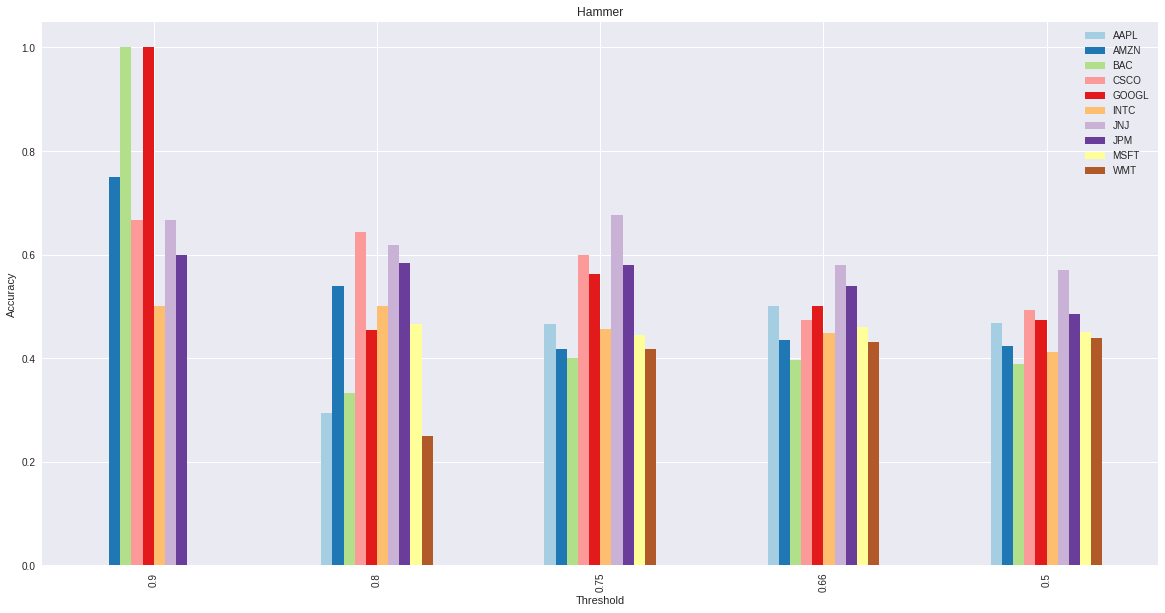

In [76]:
acc_t = {}
for i in stock_code:
  acc_t[i] = list(df_hammer[df_hammer['name']==i]['acc'])
  
df_hammer_plot = pd.DataFrame(acc_t)
# my_colors = [(x/10.0, x/10.0, 0.1) for x in range(len(df))] 
ax = df_hammer_plot.plot(kind='bar',figsize=(20,10),colormap='Paired')
ax.set_title('Hammer')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold')
ax.set_xticklabels(list_threshold)

[Text(0,0,'0.9'),
 Text(0,0,'0.8'),
 Text(0,0,'0.75'),
 Text(0,0,'0.66'),
 Text(0,0,'0.5')]

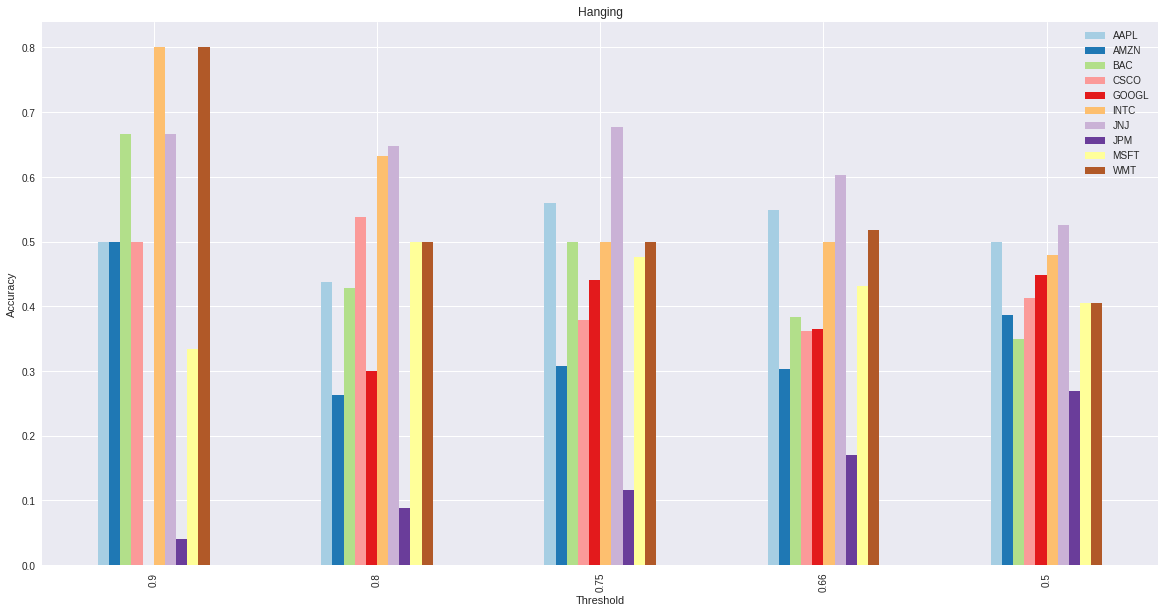

In [75]:
acc_t = {}
for i in stock_code:
  acc_t[i] = list(df_hanging[df_hanging['name']==i]['acc'])
  
df_hammer_plot = pd.DataFrame(acc_t) 
ax = df_hammer_plot.plot(kind='bar',figsize=(20,10),colormap='Paired')
ax.set_title('Hanging')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold')
ax.set_xticklabels(list_threshold)

[Text(0,0,'0.9'),
 Text(0,0,'0.8'),
 Text(0,0,'0.75'),
 Text(0,0,'0.66'),
 Text(0,0,'0.5')]

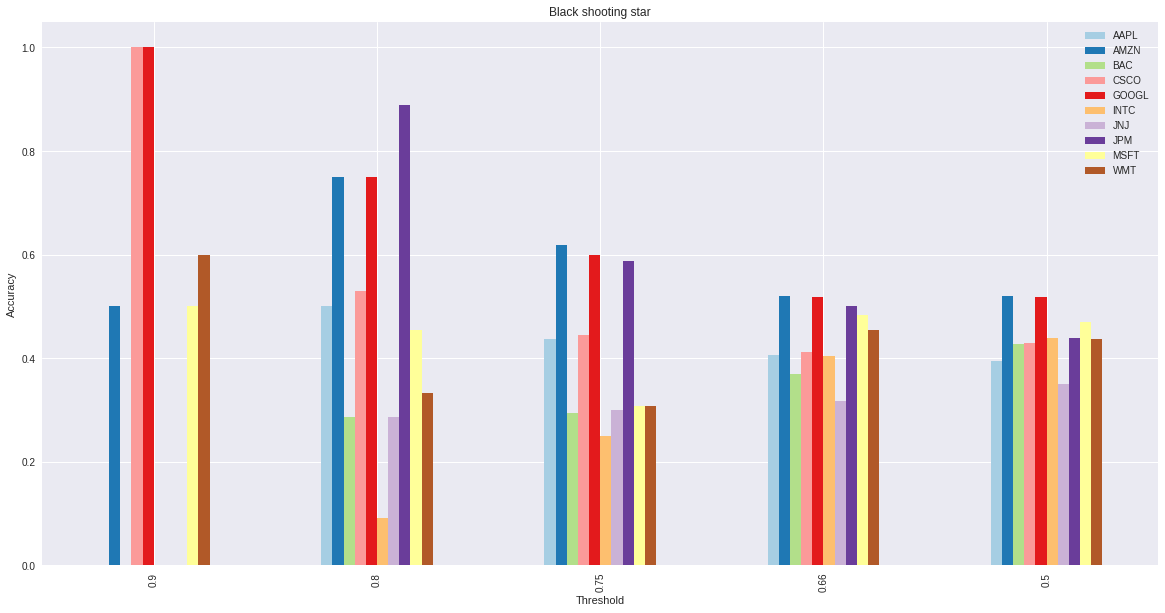

In [78]:
acc_t = {}
for i in stock_code:
  acc_t[i] = list(df_blackss[df_blackss['name']==i]['acc'])
  
df_hammer_plot = pd.DataFrame(acc_t)
ax = df_hammer_plot.plot(kind='bar',figsize=(20,10),colormap='Paired')
ax.set_title('Black shooting star')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold')
ax.set_xticklabels(list_threshold)

[Text(0,0,'0.9'),
 Text(0,0,'0.8'),
 Text(0,0,'0.75'),
 Text(0,0,'0.66'),
 Text(0,0,'0.5')]

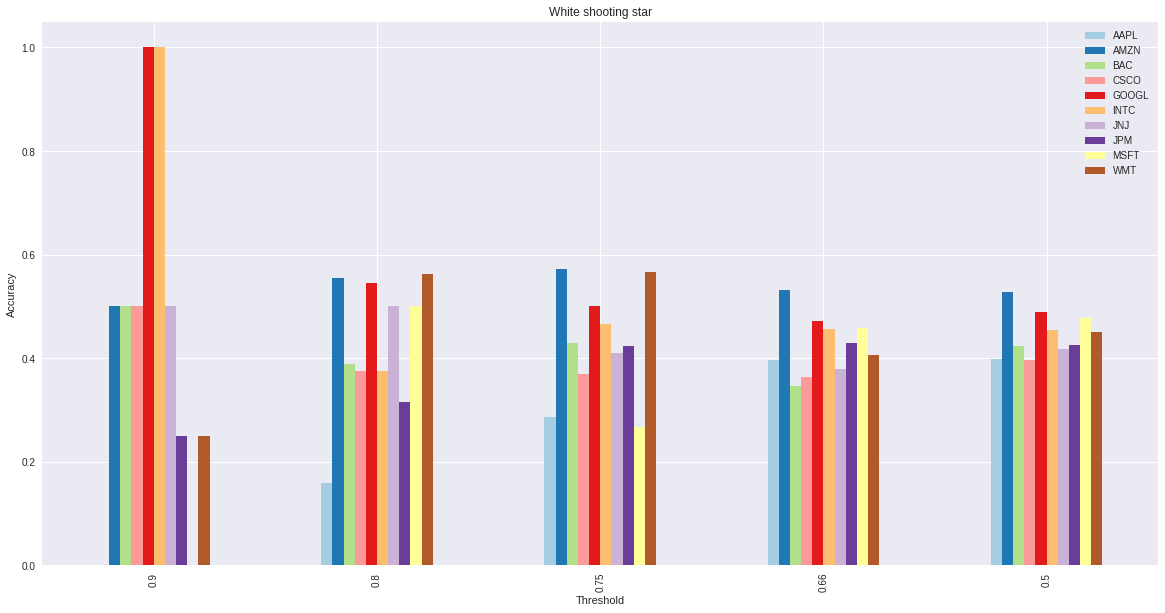

In [79]:
acc_t = {}
for i in stock_code:
  acc_t[i] = list(df_whitess[df_whitess['name']==i]['acc'])
  
df_hammer_plot = pd.DataFrame(acc_t)

ax = df_hammer_plot.plot(kind='bar',figsize=(20,10),colormap='Paired')
ax.set_title('White shooting star')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold')
ax.set_xticklabels(list_threshold)

#### Độ chính xác của mỗi pattern 

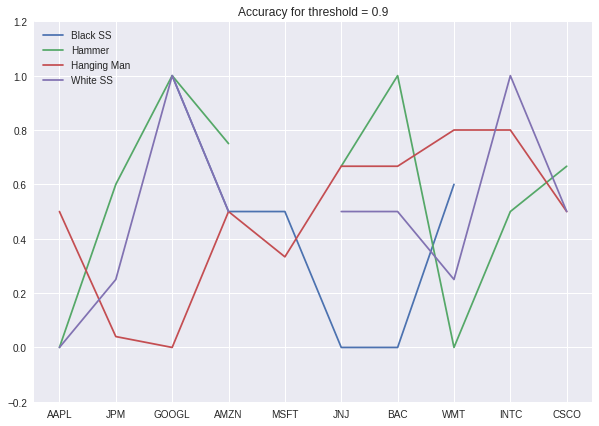

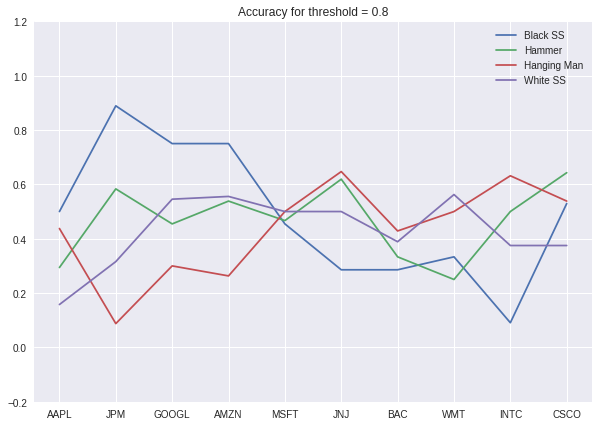

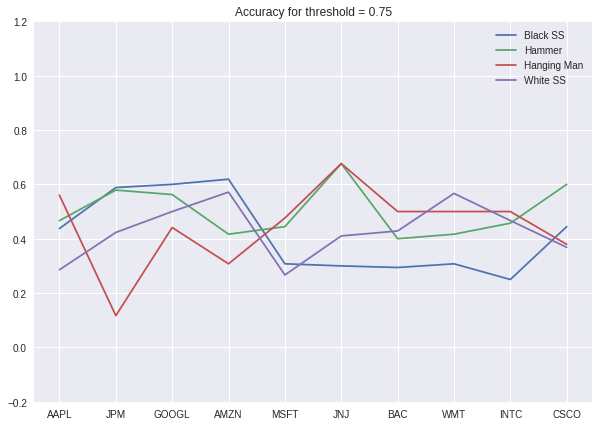

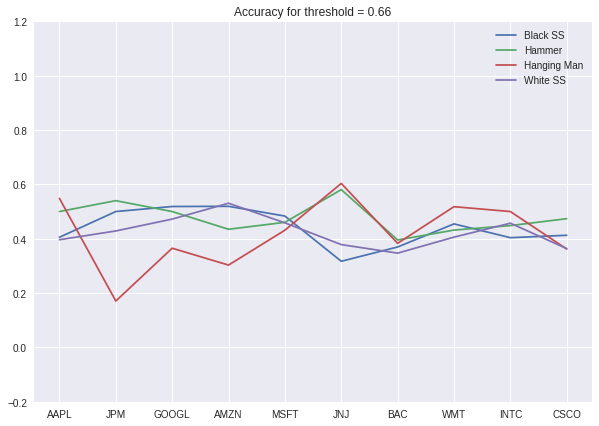

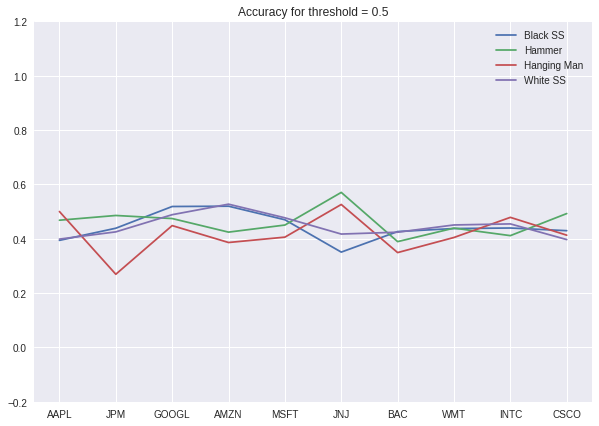

In [62]:
acc_threshold = []
for t in list_threshold:
  df_threshold = pd.DataFrame({
      'Hammer' :  list(df_hammer[df_hammer['t'] == t]['acc']),
      'Hanging Man': list(df_hanging[df_hanging['t'] == t]['acc']),
      'Black SS' : list(df_blackss[df_blackss['t'] == t]['acc']),
      'White SS' : list(df_whitess[df_whitess['t'] == t]['acc'])
  })
  ax = df_threshold.plot(figsize=(10,7))
  ax.set_title('Accuracy for threshold = '+str(t))
  ax.set_ybound(lower=-0.2,upper=1.2)
  ax.set_xticks(range(len(stock_code)))
  ax.set_xticklabels(stock_code)
  acc_threshold.append(df_threshold)

In [69]:
df_hammer[df_hammer['name']=='JNJ']

,name,t,appear,correct,acc
5,JNJ,0.90,3,2,0.666667
15,JNJ,0.80,21,13,0.619048
25,JNJ,0.75,34,23,0.676471
35,JNJ,0.66,62,36,0.580645
45,JNJ,0.50,135,77,0.570370


In [70]:
df_blackss[df_blackss['name']=='JNJ']

,name,t,appear,correct,acc
5,JNJ,0.90,2,0,0.000000
15,JNJ,0.80,14,4,0.285714
25,JNJ,0.75,20,6,0.300000
35,JNJ,0.66,41,13,0.317073
45,JNJ,0.50,134,47,0.350746


In [71]:
df_whitess[df_whitess['name']=='JNJ']

,name,t,appear,correct,acc
5,JNJ,0.90,4,2,0.500000
15,JNJ,0.80,18,9,0.500000
25,JNJ,0.75,39,16,0.410256
35,JNJ,0.66,74,28,0.378378
45,JNJ,0.50,175,73,0.417143


In [72]:
df_hanging[df_hanging['name'] == 'JNJ']

,name,t,appear,correct,acc
5,JNJ,0.90,3,2,0.666667
15,JNJ,0.80,17,11,0.647059
25,JNJ,0.75,34,23,0.676471
35,JNJ,0.66,58,35,0.603448
45,JNJ,0.50,154,81,0.525974
